# EE514 assignment part 1 starter code

Using sensors to predict activity. This part of the assignment uses the [ExtraSensory dataset](http://extrasensory.ucsd.edu/). You can download the dataset from [here](http://extrasensory.ucsd.edu/data/primary_data_files/ExtraSensory.per_uuid_features_labels.zip). The starter code expects that this dataset has been unpacked in a folder called `data` that is in the same parent folder as this notebook. You can read more about the dataset in [this README file](http://extrasensory.ucsd.edu/data/primary_data_files/README.txt).

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import os

## Location of the .csv.gz files

In [2]:
data_dir = Path('data')

## Some utility functions

The first one loads a pandas dataframe given a user UUID. The second one extracts specified feature columns $X$ and target column $y$ from a dataframe and converts these to numpy.

In [3]:
def load_data_for_user(uuid):
    return pd.read_csv(data_dir / (uuid + '.features_labels.csv.gz'))

def get_features_and_target(df, feature_names, target_name):
    
    # select out features and target columns and convert to numpy
    X = df[feature_names].to_numpy()
    y = df[target_name].to_numpy()
    
    # remove examples with no label
    has_label = ~np.isnan(y)
    X = X[has_label,:]
    y = y[has_label]
    return X, y

## Load in some data 
Load in the data for a user and display the first few rows of the dataframe

In [15]:
uuid_list =  [ i[:i.find('.')] for i in os.listdir(data_dir) ]
sum = len(uuid_list)

train_uuid = uuid_list[:int(0.8*sum)]               # 80% data for training
valid_uuid = uuid_list[int(0.8*sum):int(0.9*sum)]   # 10% data for validate
test_uuid = uuid_list[int(0.9*sum):]                # 10% data for test
# df = load_data_for_user('1155FF54-63D3-4AB2-9863-8385D0BD0A13')
# df.head([]

60


In [13]:
def get_label_pretty_name(label):
    if label == 'FIX_walking':
        return 'Walking';
    if label == 'FIX_running':
        return 'Running';
    if label == 'LOC_main_workplace':
        return 'At main workplace';
    if label == 'OR_indoors':
        return 'Indoors';
    if label == 'OR_outside':
        return 'Outside';
    if label == 'LOC_home':
        return 'At home';
    if label == 'FIX_restaurant':
        return 'At a restaurant';
    if label == 'OR_exercise':
        return 'Exercise';
    if label == 'LOC_beach':
        return 'At the beach';
    if label == 'OR_standing':
        return 'Standing';
    if label == 'WATCHING_TV':
        return 'Watching TV'
    
    if label.endswith('_'):
        label = label[:-1] + ')';
        pass;
    
    label = label.replace('__',' (').replace('_',' ');
    label = label[0] + label[1:].lower();
    label = label.replace('i m','I\'m');
    return label;

In [14]:
def figure__pie_chart(Y,label_names,labels_to_display,title_str,ax):
    portion_of_time = np.mean(Y,axis=0);
    portions_to_display = [portion_of_time[label_names.index(label)] for label in labels_to_display];
    pretty_labels_to_display = [get_label_pretty_name(label) for label in labels_to_display];
    
    ax.pie(portions_to_display,labels=pretty_labels_to_display,autopct='%.2f%%');
    ax.axis('equal');
    plt.title(title_str);
    return;

Since the collection of labels relied on self-reporting in-the-wild, the labeling may be incomplete.
For instance, the users did not always report the position of the phone.


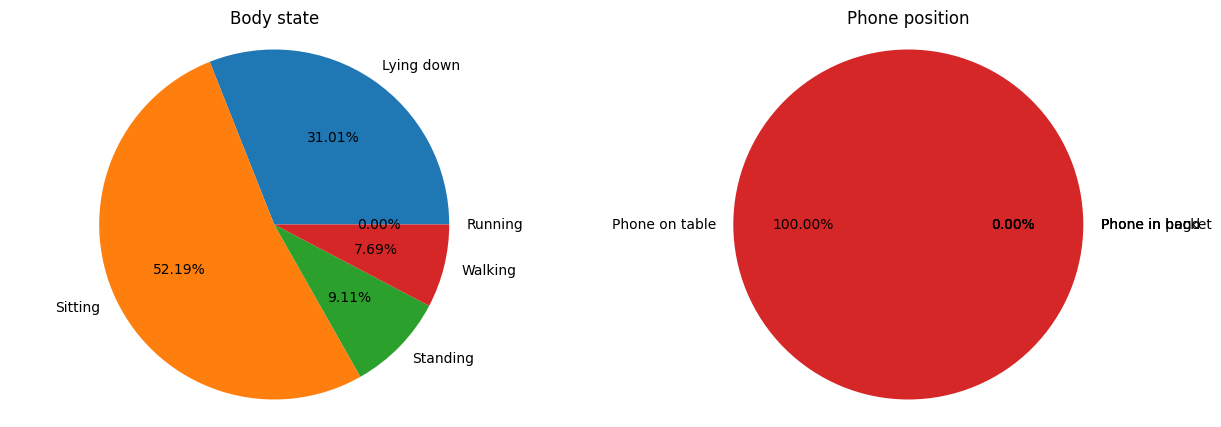

In [ ]:
print("Since the collection of labels relied on self-reporting in-the-wild, the labeling may be incomplete.");
print("For instance, the users did not always report the position of the phone.");
fig = plt.figure(figsize=(15,5),facecolor='white');

ax1 = plt.subplot(1,2,1);
labels_to_display = ['LYING_DOWN','SITTING','OR_standing','FIX_walking','FIX_running'];
figure__pie_chart(Y,label_names,labels_to_display,'Body state',ax1);

ax2 = plt.subplot(1,2,2);
labels_to_display = ['PHONE_IN_HAND','PHONE_IN_BAG','PHONE_IN_POCKET','PHONE_ON_TABLE'];
figure__pie_chart(Y,label_names,labels_to_display,'Phone position',ax2);

## What columns are available?

In [5]:
print(df.columns.to_list())

['timestamp', 'raw_acc:magnitude_stats:mean', 'raw_acc:magnitude_stats:std', 'raw_acc:magnitude_stats:moment3', 'raw_acc:magnitude_stats:moment4', 'raw_acc:magnitude_stats:percentile25', 'raw_acc:magnitude_stats:percentile50', 'raw_acc:magnitude_stats:percentile75', 'raw_acc:magnitude_stats:value_entropy', 'raw_acc:magnitude_stats:time_entropy', 'raw_acc:magnitude_spectrum:log_energy_band0', 'raw_acc:magnitude_spectrum:log_energy_band1', 'raw_acc:magnitude_spectrum:log_energy_band2', 'raw_acc:magnitude_spectrum:log_energy_band3', 'raw_acc:magnitude_spectrum:log_energy_band4', 'raw_acc:magnitude_spectrum:spectral_entropy', 'raw_acc:magnitude_autocorrelation:period', 'raw_acc:magnitude_autocorrelation:normalized_ac', 'raw_acc:3d:mean_x', 'raw_acc:3d:mean_y', 'raw_acc:3d:mean_z', 'raw_acc:3d:std_x', 'raw_acc:3d:std_y', 'raw_acc:3d:std_z', 'raw_acc:3d:ro_xy', 'raw_acc:3d:ro_xz', 'raw_acc:3d:ro_yz', 'proc_gyro:magnitude_stats:mean', 'proc_gyro:magnitude_stats:std', 'proc_gyro:magnitude_stat

## Feature selection

The columns that start with `label:` correspond to potential y values. Let's look at using the accelerometer features. These start with `raw_acc:` and `watch_acceleration:`

In [6]:
acc_sensors = [s for s in df.columns if 
               s.startswith('raw_acc:') or 
               s.startswith('watch_acceleration:')]

target_column = 'label:FIX_walking'

## Extract our training data

In [7]:
X_train, y_train = get_features_and_target(df, acc_sensors, target_column)
print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')

1665 examples with 95.0 positives


## Preprocessing

We want to make the learning problem easier by making all columns have a mean of zero and a standard deviation of one. There are also lots of missing values in this dataset. We'll use mean imputation here to get rid of them. Since our data is scaled to have zero mean, this will just zero out missing values.

In [8]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

X_train = scaler.fit_transform(X_train)
X_train = imputer.fit_transform(X_train)

## Fitting a model
Let's fit a logistic regression model to this user. We can then test it's predictive power on a different user

In [9]:
clf = LogisticRegression(solver='liblinear', max_iter=1000, C=1.0)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

## Training accuracy

Let's see the accuracy on the training set. The score function can be used to do this:

In [10]:
print(f'Training accuracy: {clf.score(X_train, y_train):0.4f}')

Training accuracy: 0.9483


Looks like the model can fit the training data reasonably well anyway. But this says nothing about how well it will generalize to new data. The dataset is also unbalanced, so this figure may be misleading. How accurate would we be if we just predicted zero each time?

In [11]:
1 - y_train.sum() / y_train.shape[0]

0.9429429429429429

Oh wow. Our model may not be that great after all. Let's try to calculate balanced accuracy, which should better reflect how well the model does on the training data

In [12]:
y_pred = clf.predict(X_train)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_train, y_pred):0.4f}')

Balanced accuracy (train): 0.5721


## Testing the model

Ok, it seems our model has fit the training data well. How well does it perform on unseen test data? Let's load the data in for a different user.

In [13]:
df_test = load_data_for_user('11B5EC4D-4133-4289-B475-4E737182A406')
X_test, y_test = get_features_and_target(df_test, acc_sensors, target_column)
print(f'{y_train.shape[0]} examples with {y_train.sum()} positives')

1665 examples with 95.0 positives


We also need to preprocess as before. **Note**: we are using the scaler and imputer fit to the training data here. It's very important that you do not call `fit` or `fit_transform` here! Think about why.

In [14]:
X_test = imputer.transform(scaler.transform(X_test))

## Test accuracy

In [15]:
print(f'Test accuracy: {clf.score(X_test, y_test):0.4f}')

Test accuracy: 0.9767


In [16]:
y_pred = clf.predict(X_test)
print(f'Balanced accuracy (train): {metrics.balanced_accuracy_score(y_test, y_pred):0.4f}')

Balanced accuracy (train): 0.6866
